In [11]:
import pandas as pd
import pprint
pd.set_option('display.max_colwidth', None)
df = pd.read_csv("april_2023.csv", dtype={'license': object})
df2 = pd.read_csv("feb_2024.csv")

threshold = 30  
columns_to_drop_df= ["id", "listing_url", "scrape_id", "host_id", "host_url", "picture_url", "host_thumbnail_url", "host_picture_url",
                     "name", "description", "neighborhood_overview", "host_about","last_scraped", "host_since", "calendar_last_scraped", 
                     "first_review", "last_review", "host_verifications", "amenities", "host_name"] # Do not make sense for PCA


# april_2023 dataset
for i in range(df.shape[1]):
    percent_nans = df.iloc[:, i].isnull().mean() * 100
    if percent_nans > threshold:
        columns_to_drop_df.append(df.columns[i])


# feb_2024 dataset:
for i in range(df2.shape[1]):
    percent_nans = df2.iloc[:, i].isnull().mean() * 100
    if percent_nans > threshold and df2.columns[i] not in columns_to_drop_df:
        columns_to_drop_df.append(df2.columns[i])

columns_to_drop_df = list(dict.fromkeys(columns_to_drop_df)) # rid column of duplicates
df.drop(columns=columns_to_drop_df, inplace=True)
df2.drop(columns=columns_to_drop_df, inplace=True)

cat_vars = []
# impute NaNs
for i, ser in enumerate(df.dtypes):
    if ser == "object":
        cat_vars.append(df.columns[i])
        df.iloc[:, i] = df.iloc[:, i].fillna('Unknown')
        df2.iloc[:, i] = df2.iloc[:, i].fillna('Unknown')
    else: #should be numerical 
        df.iloc[:, i] = df.iloc[:, i].fillna(df.iloc[:, i].median())
        df2.iloc[:, i] = df2.iloc[:, i].fillna(df2.iloc[:, i].median())

print(df.shape[1])


46


In [15]:
# Combine the datasets
combined = pd.concat([df, df2], sort=False).reset_index(drop=True)

# One-hot encode
combined_encoded = pd.get_dummies(combined, columns=cat_vars, drop_first=True, prefix=cat_vars)

# Split the datasets back
df_encoded = combined_encoded.iloc[:len(df)]
df2_encoded = combined_encoded.iloc[len(df):]


In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [17]:
# Initialize PCA model
pca = PCA(n_components=2)

# Fit and transform the 2023 dataset
pca_2023 = pca.fit_transform(df_encoded)
# Only transform the 2024 dataset using the same PCA model to ensure comparability
pca_2024 = pca.transform(df2_encoded)

# Convert the PCA results back to DataFrame for easier handling
pca_2023_df = pd.DataFrame(data=pca_2023, columns=['PC1', 'PC2'])
pca_2024_df = pd.DataFrame(data=pca_2024, columns=['PC1', 'PC2'])


In [18]:
print("Explained variance ratio for 2023:", pca.explained_variance_ratio_)
print("Explained variance ratio for 2024:", pca.explained_variance_ratio_)


Explained variance ratio for 2023: [0.85620371 0.10190983]
Explained variance ratio for 2024: [0.85620371 0.10190983]


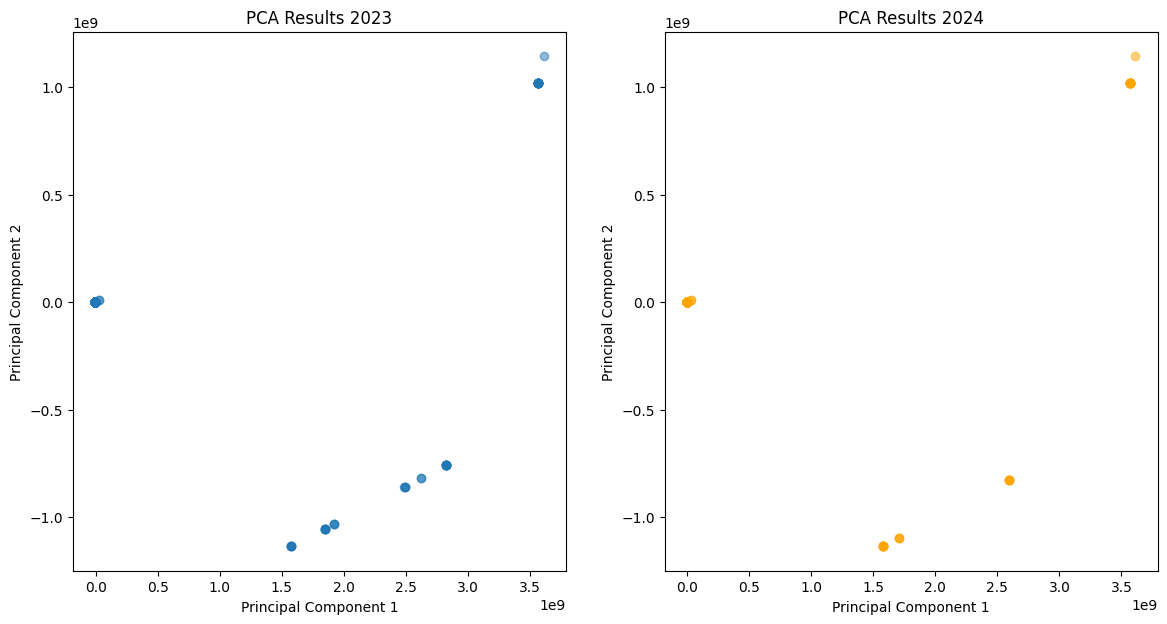

In [19]:
plt.figure(figsize=(14, 7))

# Plot for 2023
plt.subplot(1, 2, 1)
plt.scatter(pca_2023_df['PC1'], pca_2023_df['PC2'], alpha=0.5)
plt.title('PCA Results 2023')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Plot for 2024
plt.subplot(1, 2, 2)
plt.scatter(pca_2024_df['PC1'], pca_2024_df['PC2'], alpha=0.5, color='orange')
plt.title('PCA Results 2024')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()
